In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

import sys

import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root="dataset/", transform=transforms, download=True)

batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 32518267.99it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112475110.33it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 55904512.98it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17318662.52it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [6]:
class Discriminator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

    def forward(self, X):
        X = F.leaky_relu(self.fc1(X))
        X = F.leaky_relu(self.fc2(X))
        X = self.out(X)
        return torch.sigmoid(X)

In [7]:
disc_net = Discriminator()
y = disc_net(torch.randn(10, 784))
y

tensor([[0.4392],
        [0.5011],
        [0.4815],
        [0.4760],
        [0.4551],
        [0.4750],
        [0.4693],
        [0.4599],
        [0.4687],
        [0.4988]], grad_fn=<SigmoidBackward0>)

In [8]:
class Generator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 784)

    def forward(self, X):
        X = F.leaky_relu(self.fc1(X))
        X = F.leaky_relu(self.fc2(X))
        X = self.out(X)
        return torch.tanh(X)

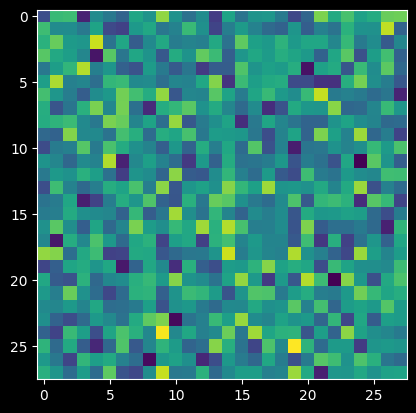

In [9]:
gen_net = Generator()
y = gen_net(torch.randn(10, 64))
plt.imshow(y[0, :].detach().squeeze().view(28, 28))
plt.show()

In [10]:
# Loss function
lossfun = nn.BCELoss()

# Create instances of the models
disc_net = Discriminator().to(device)
gen_net = Generator().to(device)

# Optimizer
d_optimizer = torch.optim.Adam(disc_net.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(gen_net.parameters(), lr=0.0003)

In [14]:
num_epochs = 50

losses = np.zeros((num_epochs*len(data_loader), 2))

for epoch in range(num_epochs):
    batch_losses = np.zeros((len(data_loader), 2))
    for count, (X, _) in enumerate(data_loader):
        real_imgs = X.view(64, 784).to(device)
        fake_imgs = gen_net(torch.randn(batch_size, 64).to(device))

        # labels used for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # --------- Train the discriminator --------- #

        # forward pass and loss for REAL images
        pred_real = disc_net(real_imgs)
        d_loss_real = lossfun(pred_real, real_labels)

        # forward pass and loss for FAKE images
        pred_fake = disc_net(fake_imgs)
        d_loss_fake = lossfun(pred_fake, fake_labels)

        # Collect loss (Using combined losses)
        d_loss = d_loss_real + d_loss_fake
        batch_losses[count, 0] = d_loss.item()


        # backprop
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()


        # --------- Train the Generator --------- #

        # Create fake images and compute loss
        fake_imgs = gen_net(torch.randn(batch_size, 64).to(device))
        pred_fake = disc_net(fake_imgs)

        # Compute and collect loss and accuracy
        g_loss = lossfun(pred_fake, real_labels)
        batch_losses[count, 1] = g_loss.item()

        # Back Prop
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print status
        msg = f"Epoch: {epoch+1}/{num_epochs}, Batches Trained: {count+1}/{len(data_loader)}"
        sys.stdout.write('\r' + msg)

    losses[epoch*len(data_loader):(epoch+1)*len(data_loader), :] = batch_losses

Epoch: 50/50, Batches Trained: 937/937

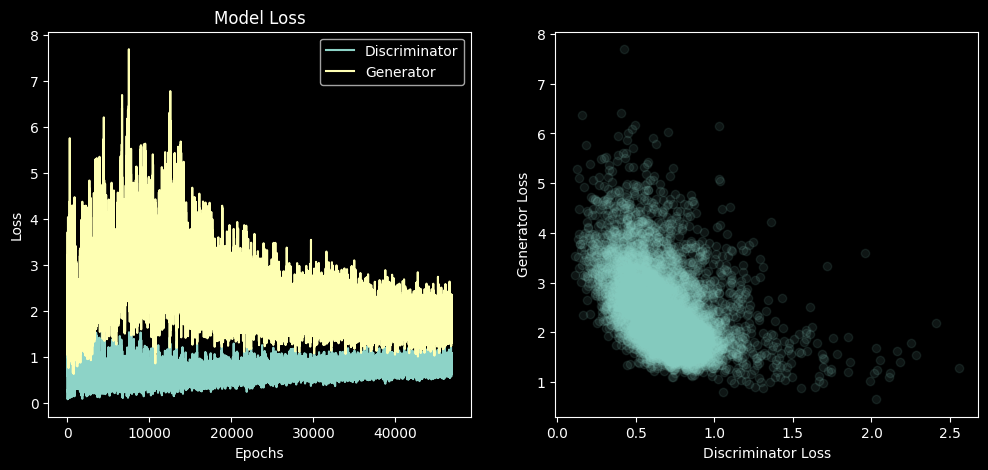

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend(['Discriminator', 'Generator'])

ax[1].scatter(losses[::5, 0], losses[::5, 1], alpha=0.1)
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

plt.show()

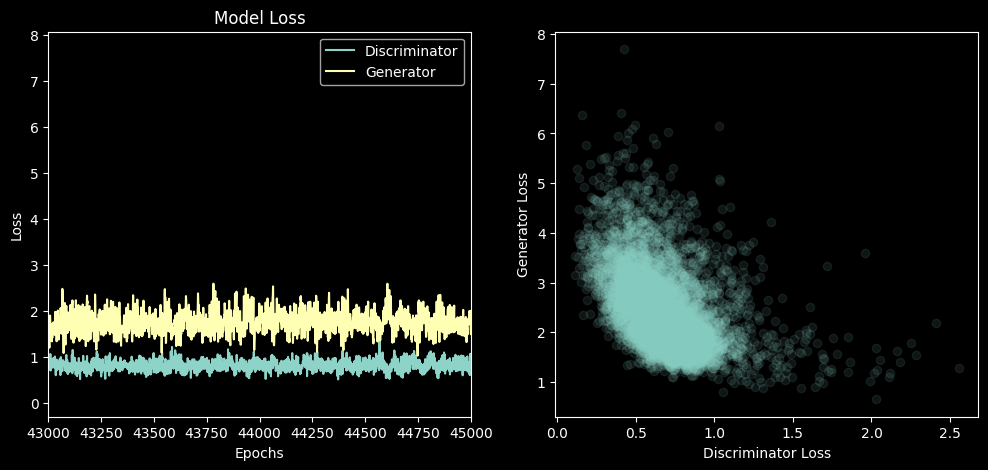

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend(['Discriminator', 'Generator'])
ax[0].set_xlim([43000, 45000])

ax[1].scatter(losses[::5, 0], losses[::5, 1], alpha=0.1)
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

plt.show()

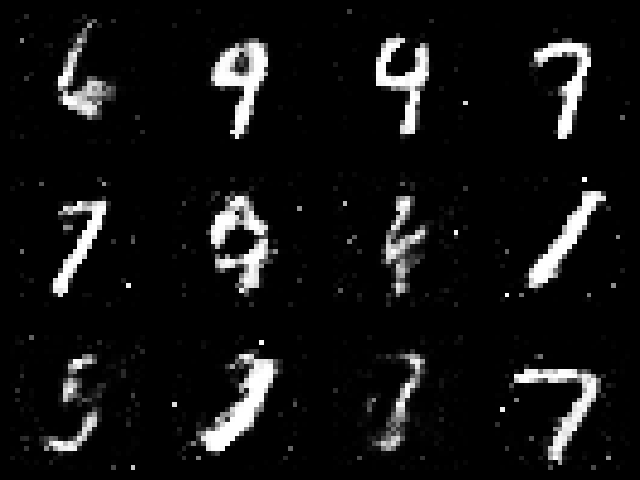

In [32]:
# Generate new images from the generator network
gen_net.eval()
fake_data = gen_net(torch.randn(12, 64).to(device)).cpu()

fig, axs = plt.subplots(3,4, figsize=(8, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i, :].detach().view(28, 28), cmap='gray')
    ax.axis('off')

plt.show()